# Deep Learning with Python

## 3.4 Classifying movie reviews: a binary classification example

> 电影评论分类:二分类问题

[原文链接](https://livebook.manning.com/book/deep-learning-with-python/chapter-3/101)

### IMDB 数据集

IMDB 数据集里是 50,000 条电影评论。一半是训练集，一半是测试集。
数据里 50% 是积极评价，50% 是消极评价。

Keras 内置了做过预处理的 IMDB 数据集，把单词序列转化成了整数序列（一个数字对应字典里的词）：

In [1]:
from tensorflow.keras.datasets import imdb

# 数据集
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

`num_words=10000` 是只保留出现频率前 10000 的单词。

先来随便看一条评论，这是条好评：

In [2]:
# 字典
index_word = {v: k for k, v in imdb.get_word_index().items()}

# 还原一条评论看看
text = ' '.join([index_word[i] for i in train_data[0]])

print(f"{train_labels[0]}:", text)

1: the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then have

### 数据准备

先看一下 train_data 现在的形状：

In [3]:
train_data.shape

(25000,)

我们要把它变成 `(samples, word_indices)` 的样子，大概是下面这种：

```
[[0, 0, ..., 1, ..., 0, ..., 1],
 [0, 1, ..., 0, ..., 1, ..., 0],
 ...
]
```

有这个词就是 1，没有就是 0。

In [4]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)


In [5]:
x_train

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

labels 也随便搞一下：

In [6]:
train_labels

array([1, 0, 0, ..., 0, 1, 0])

In [7]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [8]:
y_train

array([1., 0., 0., ..., 0., 1., 0.], dtype=float32)

现在这些数据就可以安全投喂我们一会儿建的神经网络了。

### 建立网络

对于这种输入是向量、标签是标量（甚至是 0 或 1）的问题：
使用 relu 激活的 Dense (全连接)堆起来的网络：

```python
Dense(16, activation='relu')
```

这种层的作用是 `output = relu(dot(W, input) + b)`。

16 是每层里隐藏单元(hidden unit)的个数。一个 hidden unit 就是在这层的表示空间里的一个维度。
W 的形状也是 `(input_dimension, 16)`，dot 出来就是个 16 维的向量，也就把数据投影到了 16 维的表示空间。

这个维度 (hidden unit 的数量) 可以看成对网络学习的自由度的控制。
维度越高，能学的东西越复杂，但计算消耗也越大，而且可能学到一些不重要的东西导致过拟合。

这里，我们将使用两层这种16个隐藏单元的层，
最后还有一个 sigmoid 激活的层来输出结果（在$[0, 1]$内的值），
这个结果表示预测有多可能这个数据的标签是1，即一条好评。

relu 是过滤掉负值（把输入的负值输出成0），sigmoid 是把值投到 `[0, 1]`：

![relu and sigmoid](https://tva1.sinaimg.cn/large/007S8ZIlgy1ge8cohvw31j31hi0lu49o.jpg)

在 Keras 中实现这个网络：

In [9]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#### 激活函数的作用

我们之前在 MNIST 里用过 relu 激活函数，所以*激活函数*到底是干嘛的？

一个没有激活函数的 Dense 层的作用只是一个线性变换：

```
output = dot(W, input) + b
```

如果每一层都是这种线性变换，把多个这种层叠在一起，假设空间并不会变大，所以能学到的东西很有限。

而激活函数就是在 `dot(W, input) + b` 外面套的一个函数，比如 relu 激活是 `output = relu(dot(W, input) + b)`。
利用这种激活函数，可以拓展表示空间，也就可以让网络学习到更复杂的“知识”。

### 编译模型

编译模型时，我们还需要选择损失函数、优化器和指标。

对这种最后输出 0 或 1 的二元分类问题，损失函数可以使用 `binary_crossentropy`(从名字就可以看得出来很合适啦)。

这个 *crossentropy* 中文叫交叉熵，是信息论里的，是用来衡量概率分布直接的距离的。
所以输出概率的模型经常是用这种 crossentropy 做损失的。

至于优化器，和 MNIST 一样，我们用 `rmsprop` （书里还没写为什么），指标也还是准确度：

In [10]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

因为这几个optimizer、loss、metrics 都是常用的，所以 Keras 内置了，可以直接传字符串。
但也可以传类实例来定制一些参数：

In [11]:
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

### 训练模型

为了在训练的过程中验证模型在它没见过的数据上精度如何，我们从原来的训练数据里分 10,000 个样本出来：

In [12]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

用一批 512 个样本的 mini-batches，跑 20 轮（所有x_train里的数据跑一遍算一轮），
并用刚分出来的 10,000 的样本做精度验证：

In [13]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 205us/sample - loss: 0.5340 - acc: 0.7867 - val_loss: 0.4386 - val_acc: 0.8340
Epoch 2/20
15000/15000 [==============================] - 1s 65us/sample - loss: 0.3289 - acc: 0.8997 - val_loss: 0.3309 - val_acc: 0.8740
Epoch 3/20
15000/15000 [==============================] - 1s 63us/sample - loss: 0.2416 - acc: 0.9193 - val_loss: 0.2870 - val_acc: 0.8884
Epoch 4/20
15000/15000 [==============================] - 1s 64us/sample - loss: 0.1872 - acc: 0.9397 - val_loss: 0.2768 - val_acc: 0.8888
Epoch 5/20
15000/15000 [==============================] - 1s 63us/sample - loss: 0.1541 - acc: 0.9491 - val_loss: 0.3001 - val_acc: 0.8816
Epoch 6/20
15000/15000 [==============================] - 1s 63us/sample - loss: 0.1261 - acc: 0.9606 - val_loss: 0.3043 - val_acc: 0.8807
Epoch 7/20
15000/15000 [==============================] - 1s 63us/sample - loss: 0.1036 - acc: 0.9677 - val_loss: 0

`fit` 阔以返回 history，里面保存了训练过程里每个 Epoch 的黑历史：

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

我们可以把这些东西画图出来看：

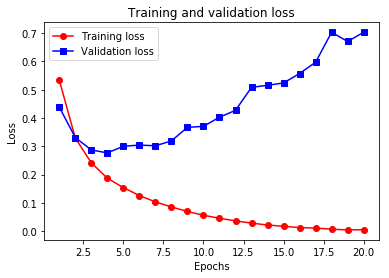

In [15]:
# 画训练和验证的损失

import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'ro-', label='Training loss')
plt.plot(epochs, val_loss_values, 'bs-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

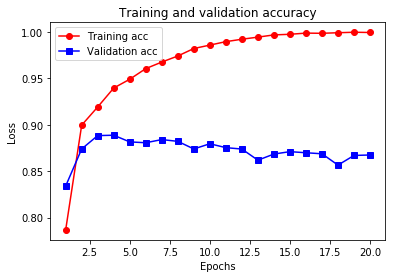

In [16]:
# 画训练和验证的准确度

plt.clf()

acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'ro-', label='Training acc')
plt.plot(epochs, val_acc, 'bs-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

我们可以看到，训练集上的精度倒是一直在增（损失一直减），
但在验证集上，到了后面损失反而大了，差不多第4轮左右就到最好的峰值了。

这就是过拟合了，其实从第二轮开始就开始过了。所以，我们其实跑个3、4轮就 ok 了。
要是再跑下去，咱的模型就只“精通”训练集，不认识其他没见过的数据了。

所以，我们重新训练一个模型（要从建立网络开始重写，不然fit是接着刚才已经进行过的这些），那去用测试集测试：

In [17]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
result = model.evaluate(x_test, y_test, verbose=2)    # verbose=2 to avoid a looooong progress bar that fills the screen with '='. https://github.com/tensorflow/tensorflow/issues/32286

Train on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 2s 69us/sample - loss: 0.4829 - accuracy: 0.8179
Epoch 2/4
25000/25000 [==============================] - 1s 42us/sample - loss: 0.2827 - accuracy: 0.9054
Epoch 3/4
25000/25000 [==============================] - 1s 42us/sample - loss: 0.2109 - accuracy: 0.9253
Epoch 4/4
25000/25000 [==============================] - 1s 43us/sample - loss: 0.1750 - accuracy: 0.9380
25000/1 - 3s - loss: 0.2819 - accuracy: 0.8836


In [18]:
result

[0.2923990402317047, 0.8836]

训练完成后，我们当然想实际试一下，对吧。所以我们预测一下测试集，把结果打出来看看：

In [19]:
model.predict(x_test)

array([[0.17157233],
       [0.99989915],
       [0.79564804],
       ...,
       [0.11750051],
       [0.05890778],
       [0.5040823 ]], dtype=float32)

### 进一步实验

1. 尝试只用一个层

In [26]:
model = models.Sequential()
# model.add(layers.Dense(16, activation='relu', input_shape=(10000, )))
# model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid', input_shape=(10000, )))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
result = model.evaluate(x_test, y_test, verbose=2)    # verbose=2 to avoid a looooong progress bar that fills the screen with '='. https://github.com/tensorflow/tensorflow/issues/32286
print(result)

Train on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 3s 116us/sample - loss: 0.5865 - accuracy: 0.7814
Epoch 2/4
25000/25000 [==============================] - 1s 31us/sample - loss: 0.4669 - accuracy: 0.8608
Epoch 3/4
25000/25000 [==============================] - 1s 32us/sample - loss: 0.3991 - accuracy: 0.8790
Epoch 4/4
25000/25000 [==============================] - 1s 33us/sample - loss: 0.3538 - accuracy: 0.8920
25000/1 - 3s - loss: 0.3794 - accuracy: 0.8732
[0.3726908649635315, 0.8732]


...这问题比较简单，一个层效果都这么好，但比之前正经的差远了

2. 多搞几个层

In [27]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
result = model.evaluate(x_test, y_test, verbose=2)    # verbose=2 to avoid a looooong progress bar that fills the screen with '='. https://github.com/tensorflow/tensorflow/issues/32286
print(result)

Train on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 3s 123us/sample - loss: 0.5285 - accuracy: 0.7614
Epoch 2/4
25000/25000 [==============================] - 1s 45us/sample - loss: 0.2683 - accuracy: 0.9072s - loss:
Epoch 3/4
25000/25000 [==============================] - 1s 45us/sample - loss: 0.1949 - accuracy: 0.9297
Epoch 4/4
25000/25000 [==============================] - 1s 47us/sample - loss: 0.1625 - accuracy: 0.9422
25000/1 - 2s - loss: 0.3130 - accuracy: 0.8806
[0.30894253887176515, 0.88056]


好一点，但也还不如正经的版本

3. 多几个隐藏层的单元

In [35]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
result = model.evaluate(x_test, y_test, verbose=2)    # verbose=2 to avoid a looooong progress bar that fills the screen with '='. https://github.com/tensorflow/tensorflow/issues/32286
print(result)

Train on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 15s 593us/sample - loss: 0.5297 - accuracy: 0.7964
Epoch 2/4
25000/25000 [==============================] - 12s 490us/sample - loss: 0.2233 - accuracy: 0.9109
Epoch 3/4
25000/25000 [==============================] - 12s 489us/sample - loss: 0.1148 - accuracy: 0.9593
Epoch 4/4
25000/25000 [==============================] - 12s 494us/sample - loss: 0.0578 - accuracy: 0.9835
25000/1 - 9s - loss: 0.3693 - accuracy: 0.8812
[0.4772889766550064, 0.8812]


不是远多越好呀。

4. 用 mse 损失

In [36]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='mse',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
result = model.evaluate(x_test, y_test, verbose=2)    # verbose=2 to avoid a looooong progress bar that fills the screen with '='. https://github.com/tensorflow/tensorflow/issues/32286
print(result)

Train on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 3s 119us/sample - loss: 0.1472 - accuracy: 0.8188
Epoch 2/4
25000/25000 [==============================] - 1s 46us/sample - loss: 0.0755 - accuracy: 0.9121
Epoch 3/4
25000/25000 [==============================] - 1s 50us/sample - loss: 0.0577 - accuracy: 0.9319
Epoch 4/4
25000/25000 [==============================] - 1s 47us/sample - loss: 0.0474 - accuracy: 0.9442
25000/1 - 3s - loss: 0.0914 - accuracy: 0.8828
[0.08648386991858482, 0.88276]


5. 用 tanh 激活

In [37]:
model = models.Sequential()
model.add(layers.Dense(16, activation='tanh', input_shape=(10000, )))
model.add(layers.Dense(16, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
result = model.evaluate(x_test, y_test, verbose=2)    # verbose=2 to avoid a looooong progress bar that fills the screen with '='. https://github.com/tensorflow/tensorflow/issues/32286
print(result)

Train on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 4s 149us/sample - loss: 0.4237 - accuracy: 0.8241
Epoch 2/4
25000/25000 [==============================] - 1s 46us/sample - loss: 0.2310 - accuracy: 0.9163
Epoch 3/4
25000/25000 [==============================] - 1s 46us/sample - loss: 0.1779 - accuracy: 0.9329
Epoch 4/4
25000/25000 [==============================] - 1s 49us/sample - loss: 0.1499 - accuracy: 0.9458
25000/1 - 3s - loss: 0.3738 - accuracy: 0.8772
[0.3238203083658218, 0.87716]


所以，这些实验就是说，之前我们书上用的模型是合理的，你改来改去都不如他那个😂。